In [1]:
visual = 10

In [2]:
import os
#os.environ - словарь переменных окружения. Изменяемый (можно добавлять и удалять переменные окружения).
os.environ['DISPLAY']=':1.0'
#MayaVi - это визуализатор научных данных, написанный на Python, который использует VTK и предоставляет графический интерфейс 
from mayavi import mlab
mlab.options.offscreen = True
mlab.init_notebook('x3d')

fcurrent = None
def fc():
    global fcurrent
    fcurrent = mlab.figure(fcurrent)
    return fcurrent
def vrmlview(fname):
    mlab.clf()
    from mayavi.sources.vrml_importer import VRMLImporter
    r = VRMLImporter()
    r.initialize(fname)
    engine = mlab.get_engine()
    f = fc()
    engine.add_source(r)
    f
    return f

Notebook initialized with x3d backend.


In [3]:
import ROOT
from math import *
import Geant4

Welcome to JupyROOT 6.18/04

**************************************************************
 Geant4 version Name: geant4-10-06-patch-01    (14-February-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

Visualization Manager instantiating with verbosity "warnings (3)"...


In [4]:
from Geant4 import cm, mm, MeV, GeV, TeV, G4ThreeVector

def material(name):
    m = Geant4.G4NistManager.Instance().FindOrBuildMaterial(name)
    return m

def particle(name):
    p = Geant4.G4ParticleTable.GetParticleTable().FindParticle(name)
    return p

# Geometry

In [5]:
#Сreate geometry:
class SomeBox:
    def __init__(self, name, materialName, parent, x, y, z, sx, sy, sz):
        self.name = name

        #do shape
        self.solid = Geant4.G4Box(self.name.lower()+"box", 0.5*sx, 0.5*sy, 0.5*sz)

        m = material(materialName)
        
        #do material
        self.logical = Geant4.G4LogicalVolume(self.solid, m, self.name, None, None, None, True)

        r0 = G4ThreeVector(x, y, z)
        
        self.physical = Geant4.G4PVPlacement(None, r0, self.logical, self.name, parent, False, 0)

In [6]:
# Create World
class World(SomeBox):
    
    def __init__(self, x, y, z, sx, sy, sz):
        super().__init__("World", "G4_Galactic", None, x, y, z, sx, sy, sz)

# Detector


In [7]:
#В 1 метре ортогонально пучку (по оси z) расположена квадратная 
#золотая пластинка толщиной 1 мм, шириной 10 см; за ней вплотную – кубический свинцовый поглотитель; размер ребра 1 м.
class DetectorConstructor(Geant4.G4VUserDetectorConstruction):
    
    def __init__(self):
        super().__init__()
        self.world = World(0, 0, 0, 200*cm, 200*cm, 500*cm)
        self.gold_plate = SomeBox("Plate", "G4_Au", self.world.logical, 0, 0, (100+0.05)*cm, 10.0*cm, 10.0*cm, 0.1*cm)
        self.absorber = SomeBox("Absorber", "G4_Pb", self.world.logical, 0, 0, (100+0.1+50)*cm, 100.0*cm, 100.0*cm, 100.0*cm)

    def Construct(self):
        return self.world.physical

# particles and their directions

In [8]:
#"В направлении по оси z испускаются электроны энергия 10 МэВ, угловой разброс 5 градусов."
class PrimaryGenerator(Geant4.G4VUserPrimaryGeneratorAction):

    def __init__(self):
        super().__init__()

        self.particlename = "e-"
        self.energy = 10.0*MeV
        
        self.gun = Geant4.G4ParticleGun()

        # set particle type
        self.particle = particle(self.particlename)
        self.gun.SetParticleDefinition(self.particle)

        pass

    def GeneratePrimaries(self, anEvent):

        # shoot initial position energy and set
        p = Geant4.G4ThreeVector(0.0, 0.0, 0.0)
        self.gun.SetParticlePosition(p)
        
        #PDG Mass - Масса частицы, выраженная в единицах эквивалентной энергии
        energy = self.energy - self.particle.GetPDGMass()
        self.gun.SetParticleEnergy(energy)

        # shoot momentum direction uniformly by solid angle and set
        phi   = ROOT.gRandom.Uniform(0.0, 2.0*pi)    
        
        tcos1 = cos(2.0*pi*5/360) #theta dispersion 
        tcos = ROOT.gRandom.Uniform(tcos1, 1.0) # Unifom disperson for all  angles
        tsin = sqrt(1.0 - tcos**2)
        
        pdir = Geant4.G4ThreeVector(tsin*cos(phi), tsin*sin(phi), tcos)
        self.gun.SetParticleMomentumDirection(pdir)

        # actual particle generator
        self.gun.GeneratePrimaryVertex(anEvent)

# Sensitive detetor
Сохраняем энергии и координаты + гистограмы

In [9]:
class SensitiveDetector(Geant4.G4VSensitiveDetector):
    
    def __init__(self, energy_hist = None, coord_hist = None):
        super().__init__()
        
        self.hit_counter = 0
        
        self.energy_hist = energy_hist
        self.coord_hist = coord_hist
        
        self.energy = 0.0 # in MeV
        self.coord_accumulator = Geant4.G4ThreeVector(0, 0, 0) 
    
    def ProcessHits (self, step, rohistory):
        self.hit_counter += 1 #попадания в 1 эвенте
    
        deposit = step.GetTotalEnergyDeposit() / MeV
        self.energy += deposit
    
        if self.coord_hist is not None:
            self.coord_accumulator += (step.GetPostStepPoint().GetPosition())*deposit 

        return True

    #сброс параметров перед новым событием
    def reset_memory(self): 
        
        self.energy = 0.0
        self.hit_counter = 0;
        self.coord_accumulator = self.coord_accumulator*0
    
    #сброс гистограм перед новым run
    def reset_hist(self):
        
        if self.energy_hist is not None:
            self.energy_hist.Reset()
        if self.coord_hist is not None:
            self.coord_hist.Reset()

    def process(self):
        #не добавлять, если нет попаданий
        if self.hit_counter > 0:
            
            if self.energy_hist is not None:
                self.energy_hist.Fill(self.energy)
            
            if self.coord_hist is not None:
                if self.energy != 0:
                    avg_X = (self.coord_accumulator.getX() / cm) / self.energy
                    avg_Y = (self.coord_accumulator.getY() / cm) / self.energy
                    self.coord_hist.Fill(avg_X, avg_Y)

#  Event action
Сброс памяти детекторов и заполнение их гистограмм

In [10]:
class EventAction(Geant4.G4UserEventAction):

    def __init__(self):
        super().__init__()
        self.detectors = set()
        self.event_counter  = 0

    def BeginOfEventAction(self, event):
        
        #сбросить гистограммы, если это первое событие
        if(self.event_counter == 0):
            for a in self.detectors:
                a.reset_hist() 
                
        #считаем энегию и координату для новых эвентов     
        for a in self.detectors: 
            a.reset_memory()
            
        self.event_counter += 1
                        
    def EndOfEventAction(self, event):
        
        for a in self.detectors:
            a.process() #fill histograms

    def registerDetector(self, a):
        self.detectors.add(a)
        
    def resetDetectorsHist(self):
        for a in self.detectors:
            a.reset_hist() 
            
    def resetCounter(self):
        self.event_counter = 0

In [11]:
#Objects
randEngine = Geant4.Ranlux64Engine()
Geant4.HepRandom.setTheEngine(randEngine)

manager = Geant4.gRunManager

In [12]:
#Physics
PhysicsList = Geant4.FTFP_BERT
physics = PhysicsList()
manager.SetUserInitialization(physics)

<<< Geant4 Physics List simulation engine: FTFP_BERT



In [13]:
#Detector and paricle generator
constructor = DetectorConstructor()
manager.SetUserInitialization(constructor)

generator = PrimaryGenerator()
manager.SetUserAction(generator)

eventcallback = EventAction()
manager.SetUserAction(eventcallback)

In [14]:
#Histograms
plate_energy = ROOT.TH1F("plate_energy", "Energy released in the pb absorber", 110, 0.0, 11.0)
absorber_energy = ROOT.TH1F("absorber_energy", "Pb absorber energy deposition", 110, 0.0, 11.0)
plate_coordinates = ROOT.TH2F("plate_coordinates", "The average x and y coordinates in the plate", 100, -5.5, 5.5, 100, -5.5, 5.5)
plate_coordinates.SetXTitle("X, cm")
plate_coordinates.SetYTitle("Y, cm")

In [15]:
#sensetive detectors
plate_sdetector = SensitiveDetector(plate_energy, plate_coordinates)
absorber_sdetector = SensitiveDetector(absorber_energy)

constructor.gold_plate.logical.SetSensitiveDetector(plate_sdetector)
constructor.absorber.logical.SetSensitiveDetector(absorber_sdetector)

eventcallback.registerDetector(plate_sdetector)
eventcallback.registerDetector(absorber_sdetector)

eventcallback.resetDetectorsHist()

In [16]:
#init all
manager.Initialize()


 FTFP_BERT : new threshold between BERT and FTFP is over the interval 
 for pions :   3 to 6 GeV
 for kaons :   3 to 6 GeV
 for proton :  3 to 6 GeV
 for neutron : 3 to 6 GeV

### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0


In [17]:
#Test run 1
manager.BeamOn(1)


phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

In [18]:
#graphs
#Geant4.gApplyUICommand("/run/initialize")
Geant4.gApplyUICommand("/vis/viewer/flush")
Geant4.gApplyUICommand("/vis/open VRML2FILE")
Geant4.gApplyUICommand("/vis/viewer/set/autoRefresh false")
Geant4.gApplyUICommand("/vis/viewer/refresh")
Geant4.gApplyUICommand("/vis/scene/create")
Geant4.gApplyUICommand("/vis/scene/add/volume")
Geant4.gApplyUICommand("/vis/viewer/set/globalLineWidthScale 5")
#Geant4.gApplyUICommand("/vis/geometry/set/colour Calorimeter red")
Geant4.gApplyUICommand("/vis/drawVolume")
#Geant4.gApplyUICommand("/vis/viewer/flush")
Geant4.gApplyUICommand("/vis/viewer/set/viewpointVector -1 -1 0")
Geant4.gApplyUICommand("/vis/viewer/set/lightsVector -1 -1 0")
Geant4.gApplyUICommand("/vis/modeling/trajectories/create/drawByParticleID")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set gamma white")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set proton blue")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set e- yellow")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set e+ green")
Geant4.gApplyUICommand("/vis/sceneHandler/attach")
Geant4.gApplyUICommand("/vis/viewer/set/style wireframe")
Geant4.gApplyUICommand("/vis/set/lineWidth 4")
#Geant4.gApplyUICommand("/vis/viewer/set/viewpointThetaPhi 120. 150.")
Geant4.gApplyUICommand("/vis/viewer/zoom 1.")
Geant4.gApplyUICommand("/tracking/storeTrajectory 1")
Geant4.gApplyUICommand("/vis/scene/add/trajectories")
Geant4.gApplyUICommand("/vis/scene/add/hits")
Geant4.gApplyUICommand("/vis/scene/add/trajectories smooth")
Geant4.gApplyUICommand("/vis/scene/endOfEventAction accumulate")
Geant4.gApplyUICommand("/vis/scene/add/scale")
Geant4.gApplyUICommand("/vis/scene/add/axes")
Geant4.gApplyUICommand("/vis/scene/add/eventID")
Geant4.gApplyUICommand("/vis/scene/add/date")
Geant4.gApplyUICommand("/vis/viewer/set/autoRefresh true")
Geant4.gApplyUICommand("/vis/enable false")
import glob, os
for i in glob.glob("g4*.wrl"):
    print("Remove",i)
    os.unlink(i)

======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             ... truncated/tracking/storeTrajectory 2
Remove g4_00.wrl


In [19]:
#10 событий с графическим отображением
Geant4.gApplyUICommand("/vis/enable true")
manager.BeamOn(10)
import glob
print(glob.glob("*.wrl"))
Geant4.gApplyUICommand("/vis/enable false")

['g4_00.wrl']


0

In [20]:
vrmlview("g4_00.wrl")

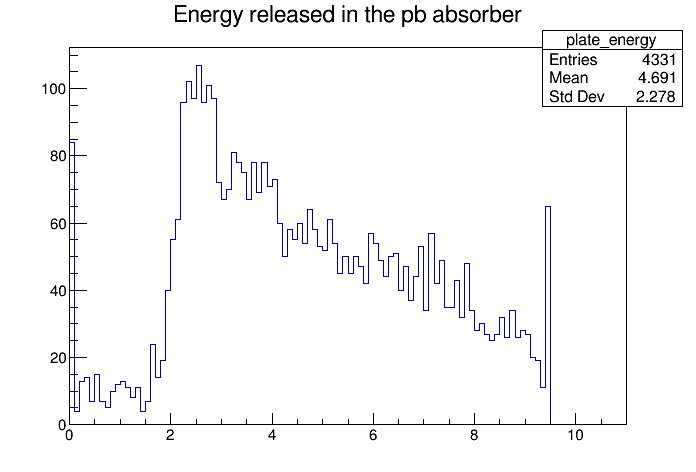

In [21]:
#1000 событий с набором гистограмм:

canvas = ROOT.TCanvas("canvas")
canvas.cd()

eventcallback.resetDetectorsHist()
eventcallback.resetCounter()
manager.BeamOn(10000)

plate_sdetector.energy_hist.Draw()
canvas.Draw()

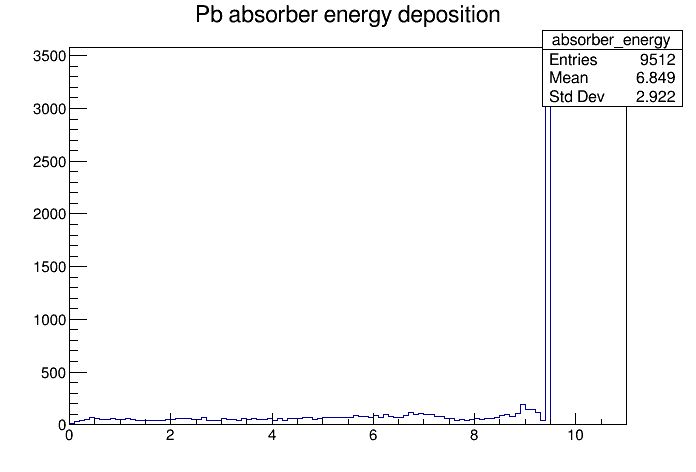

In [22]:
absorber_sdetector.energy_hist.Draw()
canvas.Draw()

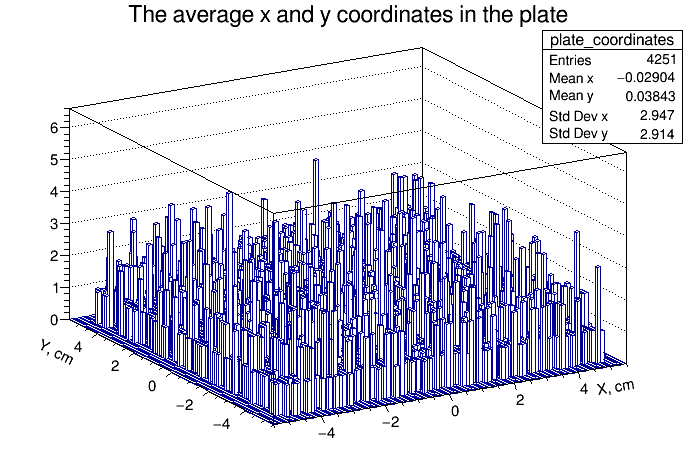

In [23]:
plate_sdetector.coord_hist.Draw("lego")
canvas.Draw()